The objective of this notebook is to run BOW and Multinomial Naive Bayes as our baseline model to have a reference in our experimentation


## Datasets

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
from mlflow.models import infer_signature
import warnings
warnings.filterwarnings('ignore')


train = pd.read_csv("../../data/gold/train.csv")
test = pd.read_csv("../../data/gold/test.csv")
val = pd.read_csv("../../data/gold/validation.csv")

X_train = train['features']
y_train = train['target']
X_test = test['features']
y_test = test['target']


signature = infer_signature(X_train, y_train)

## Pipeline

In [2]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    fbeta_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    auc,
    balanced_accuracy_score,
    roc_curve
)


pipeline = Pipeline([
        ('vectorizer', CountVectorizer(ngram_range=(1, 1), max_features=None)),
        ('classifier', MultinomialNB())
    ])
    
pipeline.fit(X_train, y_train)
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)




### Metrics

In [3]:
train_report = classification_report(y_train, y_train_pred, target_names = ['ham', 'spam'], digits=3)
print("Classification Report (Train Data):")
print(train_report)

test_report = classification_report(y_test, y_test_pred, target_names = ['ham', 'spam'], digits=3)
print("Classification Report (Test Data):")
print(test_report)

Classification Report (Train Data):
              precision    recall  f1-score   support

         ham      0.995     0.995     0.995      3606
        spam      0.967     0.967     0.967       517

    accuracy                          0.992      4123
   macro avg      0.981     0.981     0.981      4123
weighted avg      0.992     0.992     0.992      4123

Classification Report (Test Data):
              precision    recall  f1-score   support

         ham      0.993     0.982     0.988       453
        spam      0.882     0.952     0.916        63

    accuracy                          0.979       516
   macro avg      0.938     0.967     0.952       516
weighted avg      0.980     0.979     0.979       516



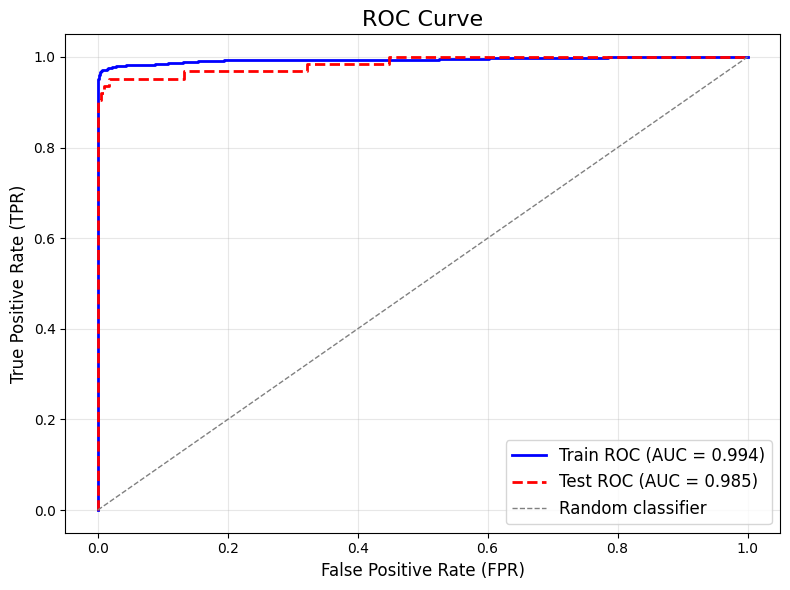

In [4]:
y_test_prob = pipeline.predict_proba(X_test)[:, 1]
y_train_prob = pipeline.predict_proba(X_train)[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)

auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Train ROC (AUC = {auc_train:.3f})', color='blue', linewidth=2)
plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {auc_test:.3f})', color='red', linestyle='--', linewidth=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=1, label='Random classifier')
plt.title('ROC Curve', fontsize=16)
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Notes:

- Accuracy: can be ignored for the evaluation of the model in the original datasets. Related to the performance having high train/test/val accuracy means that the model is not overfitting but it can be that the dataset is small and the rows are similar enough. It would be nice to perform CV, find more data or increase model complexity to check if the performance of the test set decreases. 

- Precision on test: 88% of the predicted positives are true positives. Good performance.

- Recall on test: 95% of the real positives are true positives. Good performance.

- F1-score: the model is doing a decent job with a 92% but since the dataset is imbalanced and I want to focus on the false positives, I take it with a grain of salt. 

- Weighted avgs: they also look good.

- Macro-averaged Precision/Recall/F1 can be ignored.

The similar metrics of train and test let us understand that the model is not overfitting and is taking into consideration every class.

In [5]:
balanced_accuracy = balanced_accuracy_score(y_test, y_test_pred)
print(f"Balanced Test Accuracy: {balanced_accuracy:.3f}")

f0_5_score = fbeta_score(y_test, y_test_pred, beta=0.5)
print(f"F0.5-Score: {f0_5_score:.3f}")

Balanced Test Accuracy: 0.967
F0.5-Score: 0.896


Notes: 

- Balanced accuracy: 97% is a good performance.

- f0.5-score: the metric chosen since I want to give more important to the false positives. A value of 0.896 indicates good performance of the model. 


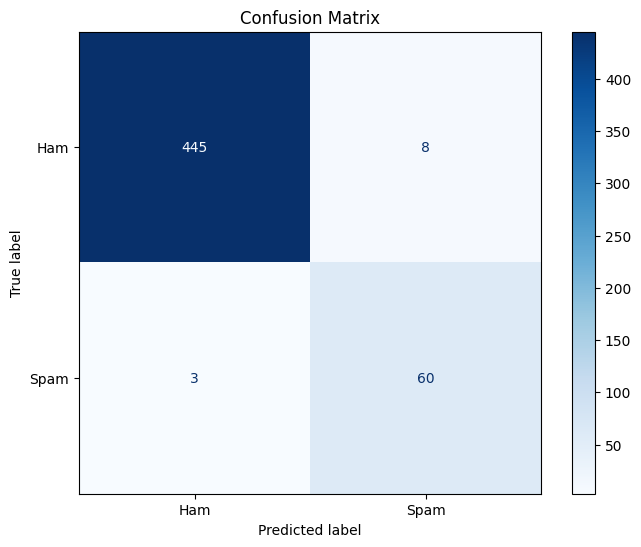

In [6]:
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
matrix_fig, ax = plt.subplots(figsize=(8, 6))
cm_display = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=['Ham', 'Spam'])
cm_display.plot(cmap='Blues', ax=ax)
plt.title("Confusion Matrix")
plt.show()

Notes:

The confusion matrix looks very good.
- 8 e-mails were predicted as SPAM but they were HAM. (these are the ones I will try to minimize)
- 3 e-mails were predicted as HAM but they were SPAM.

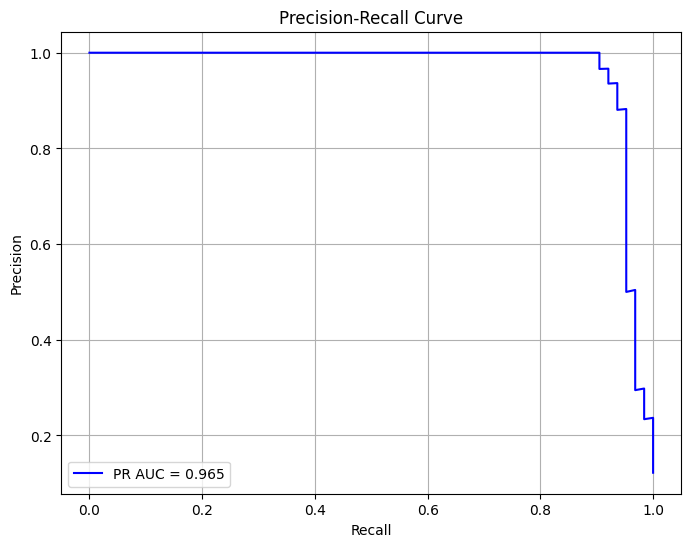

In [7]:
y_test_pred_prob = pipeline.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_test_pred_prob)
pr_auc = auc(recall, precision)

pr_fig, ax = plt.subplots(figsize=(8, 6))  
ax.plot(recall, precision, color='b', label=f'PR AUC = {pr_auc:.3f}')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve')
ax.legend(loc="best")
ax.grid(True)
plt.show()


Notes: 

The area under the curve is 0.96 so the model strikes a strong balance between precision and recall across thresholds. The model identifies spam effectively without producing excessive false positives.

## MLFlow config


In [8]:
import sys 
sys.path.append("../utils")
import os
import mlflow
from experiments_utils import experiment_status

mlflow_tracking_uri = os.getenv("MLFLOW_TRACKING_URI")
aws_access_key_id = os.getenv("AWS_ACCESS_KEY_ID")
aws_secret_access_key = os.getenv("AWS_SECRET_ACCESS_KEY")
aws_default_region = os.getenv("AWS_DEFAULT_REGION")

mlflow.set_tracking_uri(mlflow_tracking_uri)

import boto3
boto3.client('s3', aws_access_key_id=aws_access_key_id, aws_secret_access_key=aws_secret_access_key, region_name=aws_default_region)


experiment_name, _, _ = experiment_status()
mlflow.set_experiment(experiment_name)

2024-12-26 17:07:13,093 - INFO - Loading configuration from: /home/maldu/dscience/projects/spam_detector/research/02_baseline_model/../utils/experiments_config.yaml


2024-12-26 17:07:13,095 - INFO - Configuration successfully loaded.


2024-12-26 17:07:13,109 - DEBUG - Starting new HTTP connection (1): ec2-3-72-255-44.eu-central-1.compute.amazonaws.com:5000


## MlFlow tracking

In [ ]:
   
with mlflow.start_run(run_name="baseline-model", log_system_metrics=True) as run:
    
    # Tags
    mlflow.set_tag("dataset", "Spam detection")
    mlflow.set_tag("task", "classification")
    mlflow.set_tag("vectorizer", "CountVectorizer")
    mlflow.set_tag("algorithm", "Multinomial Naive Bayes")
    mlflow.set_tag("framework", "Scikit-learn")
    mlflow.set_tag("language", "Python")
    mlflow.set_tag("environment", "Local")
    mlflow.set_tag("dataset_version", "1.0.0")
    mlflow.set_tag("preprocessing_version", "1.0.0")
    mlflow.set_tag("model_version", "0.0.1")
    mlflow.set_tag("developer", "Mldu")
    mlflow.set_tag("project_stage", "testing")


    #Datasets
    mlflow.log_input(mlflow.data.from_pandas(train, name="train dataset", targets="target"))
    mlflow.log_input(mlflow.data.from_pandas(test, name="test dataset", targets="target"))
    mlflow.log_input(mlflow.data.from_pandas(val, name="validation dataset", targets="target"))
    mlflow.log_artifact("../../data/gold/train.csv")
    mlflow.log_artifact("../../data/gold/test.csv")
    mlflow.log_artifact("../../data/gold/validation.csv")

    
    #BOW and model
    mlflow.log_param("vectorizer_type", "CountVectorizer")
    mlflow.log_param("model_type", "MultinomialNB")
    
    # Metrics
    mlflow.log_metric("balanced_accuracy", balanced_accuracy)
    mlflow.log_metric("f0_5_score", f0_5_score)
    cr = classification_report(y_test, y_test_pred, output_dict=True)
    mlflow.log_metric("accuracy", cr.pop("accuracy"))
    for class_or_avg, metrics_dict in cr.items():
        for metric, value in metrics_dict.items():
            mlflow.log_metric(class_or_avg + '_' + metric,value)
    
    # Figures
    mlflow.log_figure(matrix_fig, "confusion-matrix.png")
    mlflow.log_figure(pr_fig, "precision-recall-curve.png")
    
    # CountVectorizer and MNB
    mlflow.sklearn.log_model(pipeline, "pipeline",signature=signature)


    print(f"Pipeline logged to MLflow under run ID {run.info.run_id}")